(mmm_time_slice_cross_validation)=
# Time-Slice-Cross Validation and Stability for Media Mix Models

In this notebook we will illustrate how to perform time-slice cross validation for a media mix model. This is an important step to evaluate the stability and quality of the model. We not only look into out of sample predictions but also the stability of the model parameters.

## Prepare Notebook

In [ ]:
import warnings
from dataclasses import dataclass

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

from pymc_marketing.metrics import crps
from pymc_marketing.mmm import (
    MMM,
    GeometricAdstock,
    LogisticSaturation,
)
from pymc_marketing.mmm.utils import apply_sklearn_transformer_across_dim
from pymc_marketing.paths import data_dir
from pymc_marketing.prior import Prior

warnings.simplefilter(action="ignore", category=FutureWarning)

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"


%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [2]:
seed: int = sum(map(ord, "mmm"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

## Read Data

We use the same data as in the example notebook {ref}`mmm_example`.

In [3]:
data_path = data_dir / "mmm_example.csv"

data_df = pd.read_csv(data_path, parse_dates=["date_week"])

data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179 entries, 0 to 178
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date_week  179 non-null    datetime64[ns]
 1   y          179 non-null    float64       
 2   x1         179 non-null    float64       
 3   x2         179 non-null    float64       
 4   event_1    179 non-null    float64       
 5   event_2    179 non-null    float64       
 6   dayofyear  179 non-null    int64         
 7   t          179 non-null    int64         
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 11.3 KB


## Specify Time-Slice-Cross-Validation Strategy

The main idea of the time-slice cross validation process is to fit the model on a time slice of the data and then evaluate it on the next time slice. We repeat this process for each time slice of the data. As we want to simulate a production-like environment where we enlarge our training data over time, we make the time-slice size grow over time.

Following the strategy of the example notebook, we use the costs share of each channel to set the prior standard deviation of the beta parameters. We need to compute this share for each training time slice independently.

```{admonition} Data Leakage
:class: warning

It is very important to avoid data leakage when performing time-slice cross validation. This means that the model should not see any training data from the future. This also includes any data pre-processing steps!

For example, as mentioned above, we need to compute the costs share for each training time slice independently if we want to avoid data leakage. Other sources of data leakage include using a global feature for thr trend component. In our case, we simply use an increasing variable `t` so we are safe as we just increase it by one for each time slice.
```

We wrap the main steps of the training procedure in a set of functions.

In [4]:
def compute_sigma_from_costs(
    X: pd.DataFrame, channel_columns: list[str]
) -> list[float]:
    """Compute the prior standard deviation of the beta parameters from the costs share of each channel."""
    n_channels = len(channel_columns)
    total_spend_per_channel = X[channel_columns].sum(axis=0)
    spend_share = total_spend_per_channel / total_spend_per_channel.sum()
    prior_sigma = n_channels * spend_share.to_numpy()
    return prior_sigma.tolist()


def get_mmm(X: pd.DataFrame, channel_columns: list[str]) -> MMM:
    """Specify the model."""
    prior_sigma = compute_sigma_from_costs(X, channel_columns)

    model_config = {
        "intercept": Prior("Normal", mu=0, sigma=0.5),
        "saturation_beta": Prior("HalfNormal", sigma=prior_sigma, dims="channel"),
        "gamma_control": Prior("Normal", mu=0, sigma=0.05, dims="control"),
        "likelihood": Prior("Normal", sigma=Prior("Exponential", lam=1 / 10)),
    }

    return MMM(
        adstock=GeometricAdstock(l_max=8),
        saturation=LogisticSaturation(),
        date_column="date_week",
        channel_columns=channel_columns,
        control_columns=[
            "event_1",
            "event_2",
            "t",
        ],
        yearly_seasonality=2,
        model_config=model_config,
    )


def fit_mmm(
    mmm: MMM, X: pd.DataFrame, y: pd.Series, random_seed: np.random.Generator
) -> MMM:
    """Fit the model."""
    fit_kwargs = {
        "tune": 1_000,
        "chains": 4,
        "draws": 1_000,
        "nuts_sampler": "numpyro",
        "random_seed": random_seed,
    }
    _ = mmm.fit(X, y, progressbar=False, **fit_kwargs)
    _ = mmm.sample_posterior_predictive(
        X, extend_idata=True, combined=True, progressbar=False, random_seed=random_seed
    )
    return mmm

For the sake of convenience, we define a data container to store the results of the time-slice cross validation step.

In [5]:
@dataclass
class TimeSliceCrossValidationResult:
    """Container for the results of the time slice cross validation."""

    X_train: pd.DataFrame
    y_train: pd.Series
    X_test: pd.DataFrame
    y_test: pd.Series
    mmm: MMM
    y_pred_test: pd.Series

Finally, we define the main function that performs the time-slice cross validation step by calling the functions defined above.

In [6]:
def time_slice_cross_validation_step(
    X_train: pd.DataFrame, y_train: pd.Series, X_test: pd.DataFrame, y_test: pd.Series
) -> TimeSliceCrossValidationResult:
    """Time-slice cross validation step.

    We fit the model on the training data and generate predictions for the test data.

    Parameters
    ----------
    X_train: pd.DataFrame
        Training data.
    y_train: pd.Series
        Training target.
    X_test: pd.DataFrame
        Test data.
    y_test: pd.Series
        Test target.

    Returns
    -------
    TimeSliceCrossValidationResult
        Results of the time slice cross validation step.
    """
    mmm = get_mmm(X_train, channel_columns=["x1", "x2"])
    mmm = fit_mmm(mmm, X_train, y_train, rng)

    y_pred_test = mmm.sample_posterior_predictive(
        X_pred=X_test,
        include_last_observations=True,
        original_scale=True,
        extend_idata=False,
        progressbar=False,
    )

    return TimeSliceCrossValidationResult(
        X_train=X_train,
        y_train=y_train,
        X_test=X_test,
        y_test=y_test,
        mmm=mmm,
        y_pred_test=y_pred_test,
    )

We are now ready to run the time-slice cross validation loop 💪!

## Run Time-Slice-Cross-Validation Loop

Depending on the business requirements, we need to decide the initial number of observations to use for fitting the model (`n_init`) and the forecast horizon (`forecast_horizon`). For this example, we use the first 158 observations to fit the model and then predict the next 12 observations (3 months).

In [7]:
X = data_df[["date_week", "x1", "x2", "event_1", "event_2", "t"]]
y = data_df["y"]

In [8]:
n_init = 158
forecast_horizon = 12
n_iterations = y.size - n_init - forecast_horizon + 1

Let's run it! 

In [9]:
results: list[TimeSliceCrossValidationResult] = []


for iteration in tqdm(range(n_iterations)):
    # Split data into train and test
    train_test_split = iteration + n_init
    X_train = X.iloc[:train_test_split]
    y_train = y.iloc[:train_test_split]
    X_test = X.iloc[train_test_split : train_test_split + forecast_horizon]
    y_test = y.iloc[train_test_split : train_test_split + forecast_horizon]

    step = time_slice_cross_validation_step(X_train, y_train, X_test, y_test)
    results.append(step)

  0%|          | 0/10 [00:00<?, ?it/s]

Sampling: [y]
Sampling: [y]
Sampling: [y]
Sampling: [y]
Sampling: [y]
Sampling: [y]
Sampling: [y]
Sampling: [y]
Sampling: [y]
Sampling: [y]
Sampling: [y]
Sampling: [y]
Sampling: [y]
Sampling: [y]
Sampling: [y]
Sampling: [y]
Sampling: [y]
Sampling: [y]
Sampling: [y]
Sampling: [y]


## Model Diagnostics

First, we evaluate whether we have any divergences in the model (we can extend the analysis more more model diagnostics).

In [10]:
sum([result.mmm.idata["sample_stats"]["diverging"].sum().item() for result in results])

0

We have no divergences in the model 😃!

## Evaluate Parameter Stability

Next, we look at the stability of the model parameters. For a good model, these should not change abruptly over time.

- Adstock Alpha

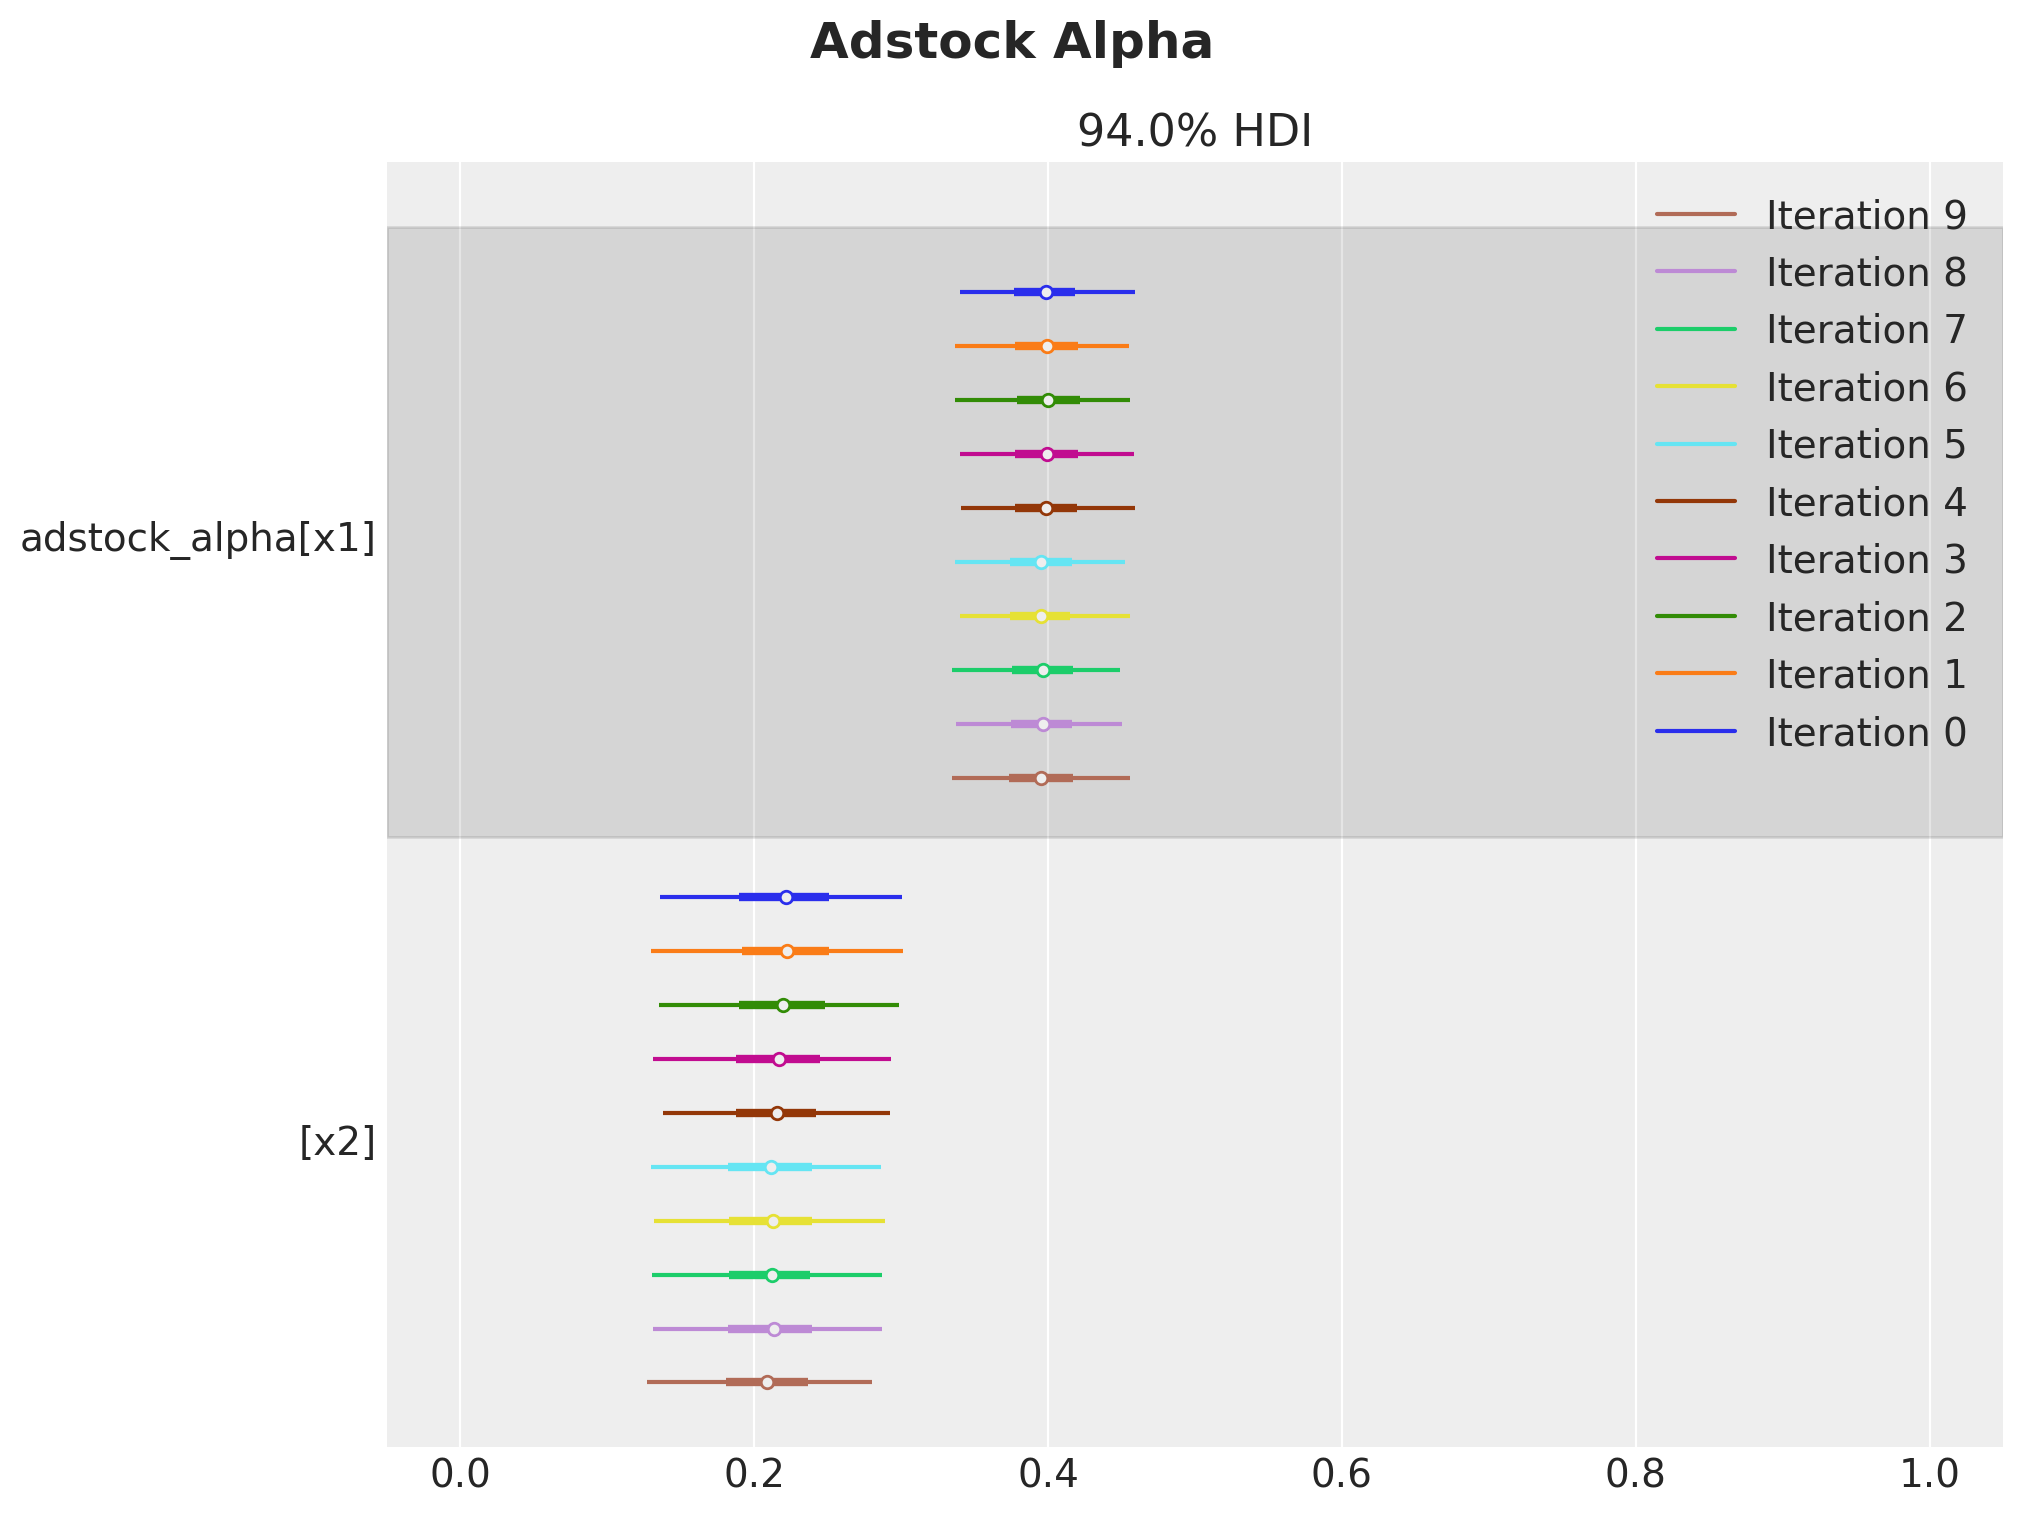

In [11]:
fig, ax = plt.subplots(figsize=(10, 7))

az.plot_forest(
    data=[result.mmm.idata["posterior"] for result in results],
    model_names=[f"Iteration {i}" for i in range(n_iterations)],
    var_names=["adstock_alpha"],
    combined=True,
    ax=ax,
)
fig.suptitle("Adstock Alpha", fontsize=18, fontweight="bold", y=1.06);

- Saturation Beta

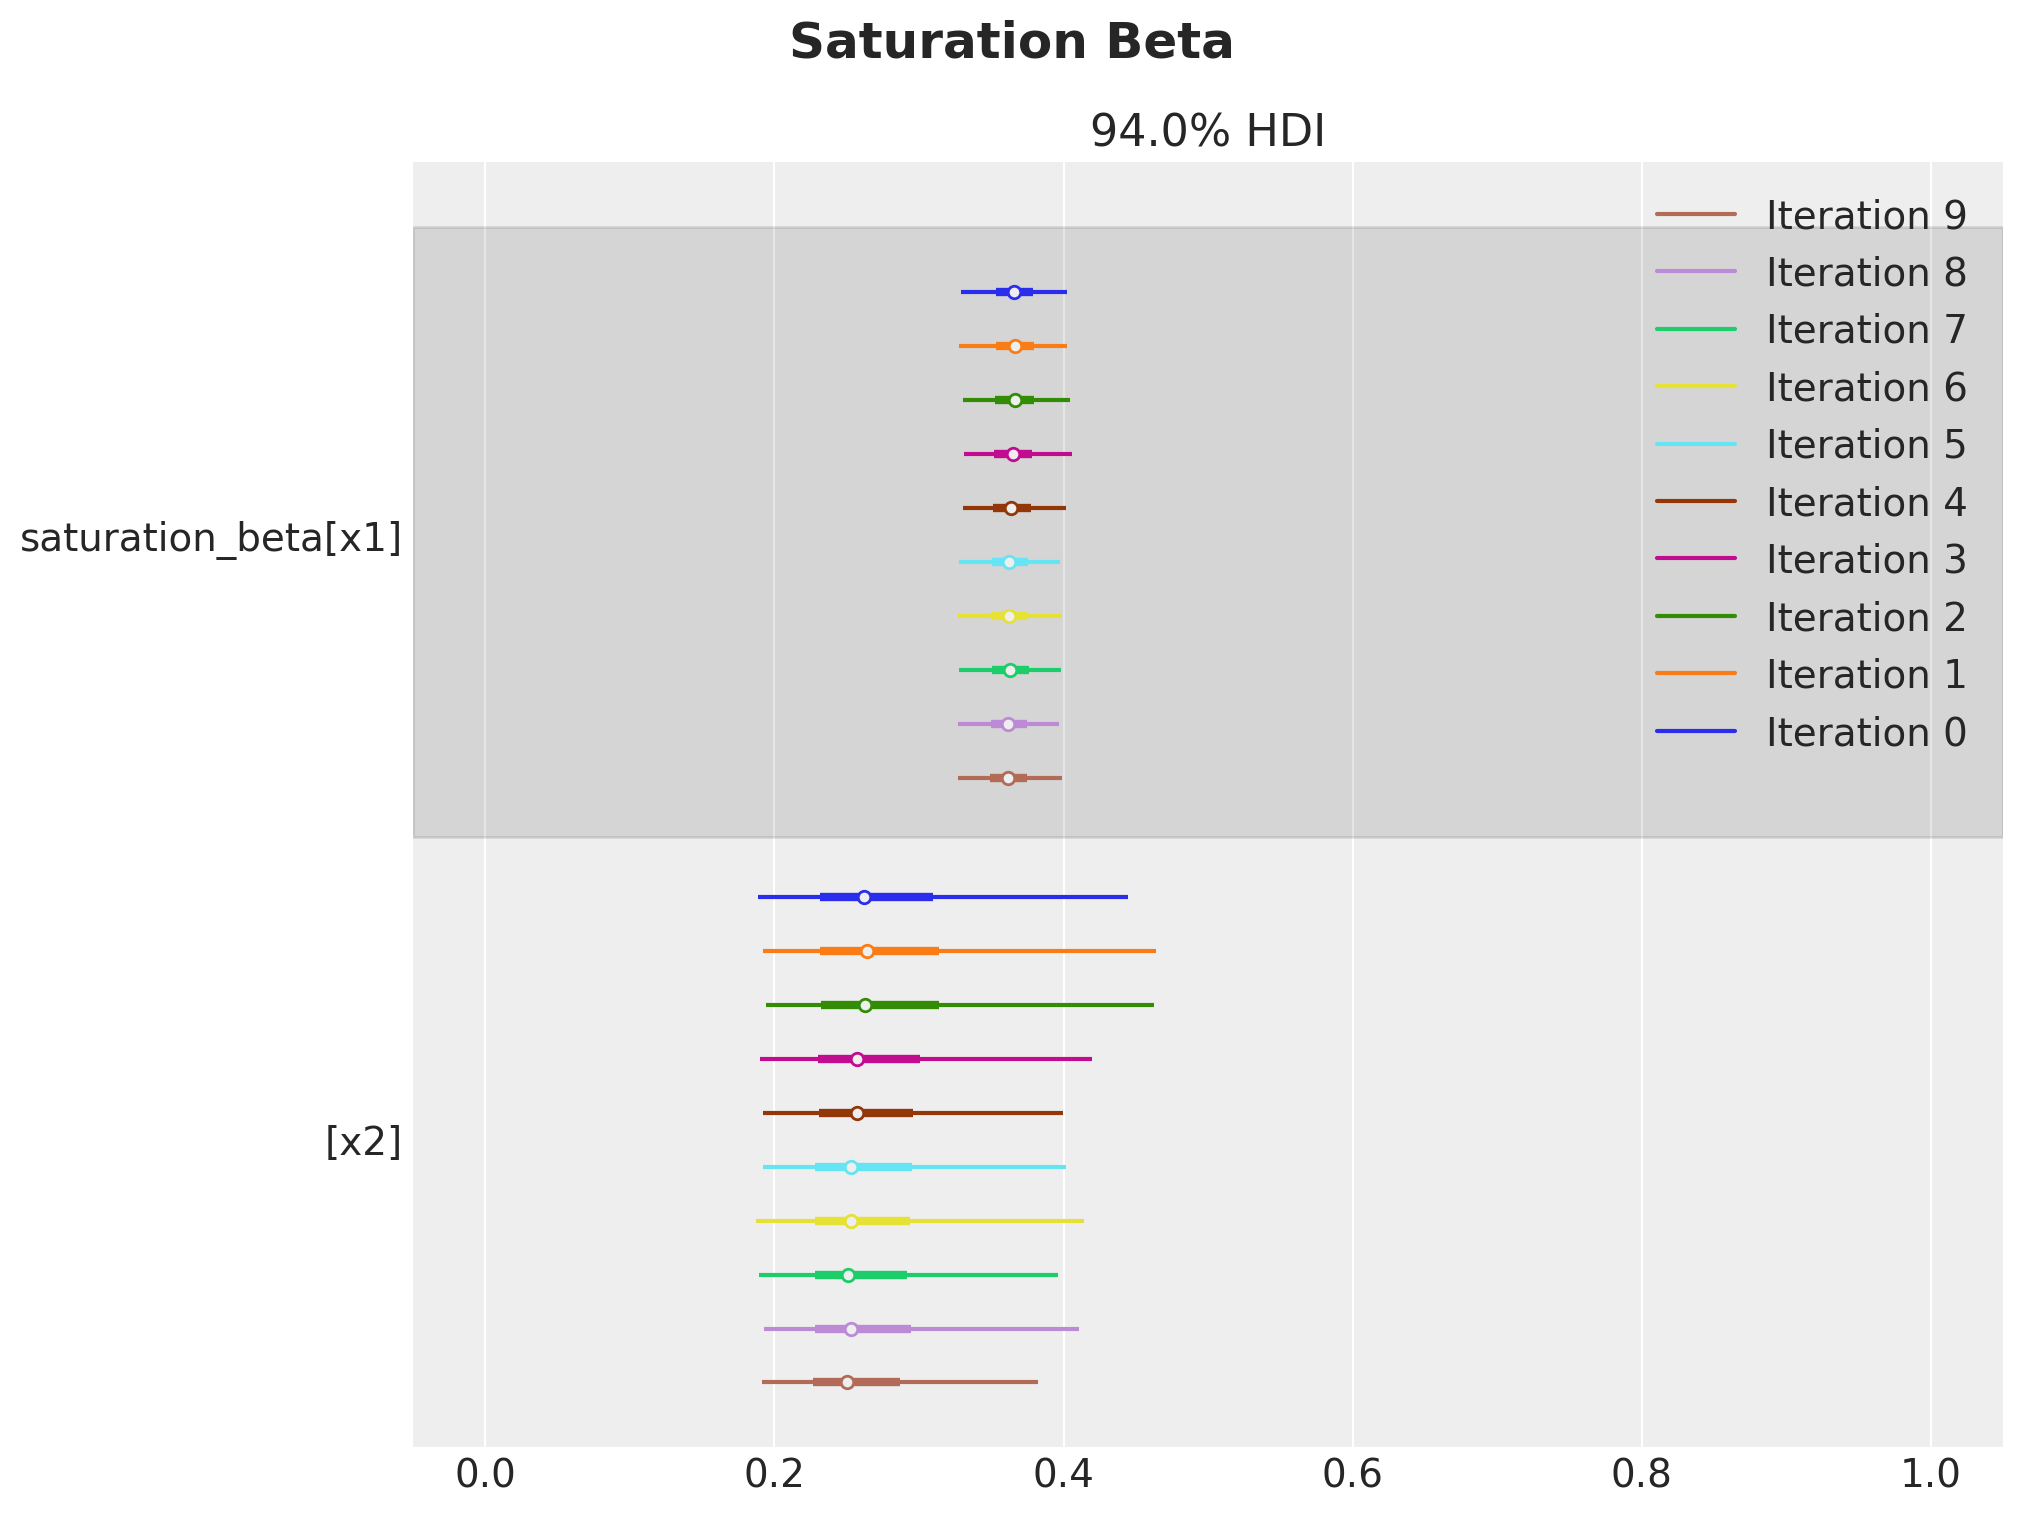

In [12]:
fig, ax = plt.subplots(figsize=(10, 7))

az.plot_forest(
    data=[result.mmm.idata["posterior"] for result in results],
    model_names=[f"Iteration {i}" for i in range(n_iterations)],
    var_names=["saturation_beta"],
    combined=True,
    ax=ax,
)
fig.suptitle("Saturation Beta", fontsize=18, fontweight="bold", y=1.06);

- Saturation Lambda

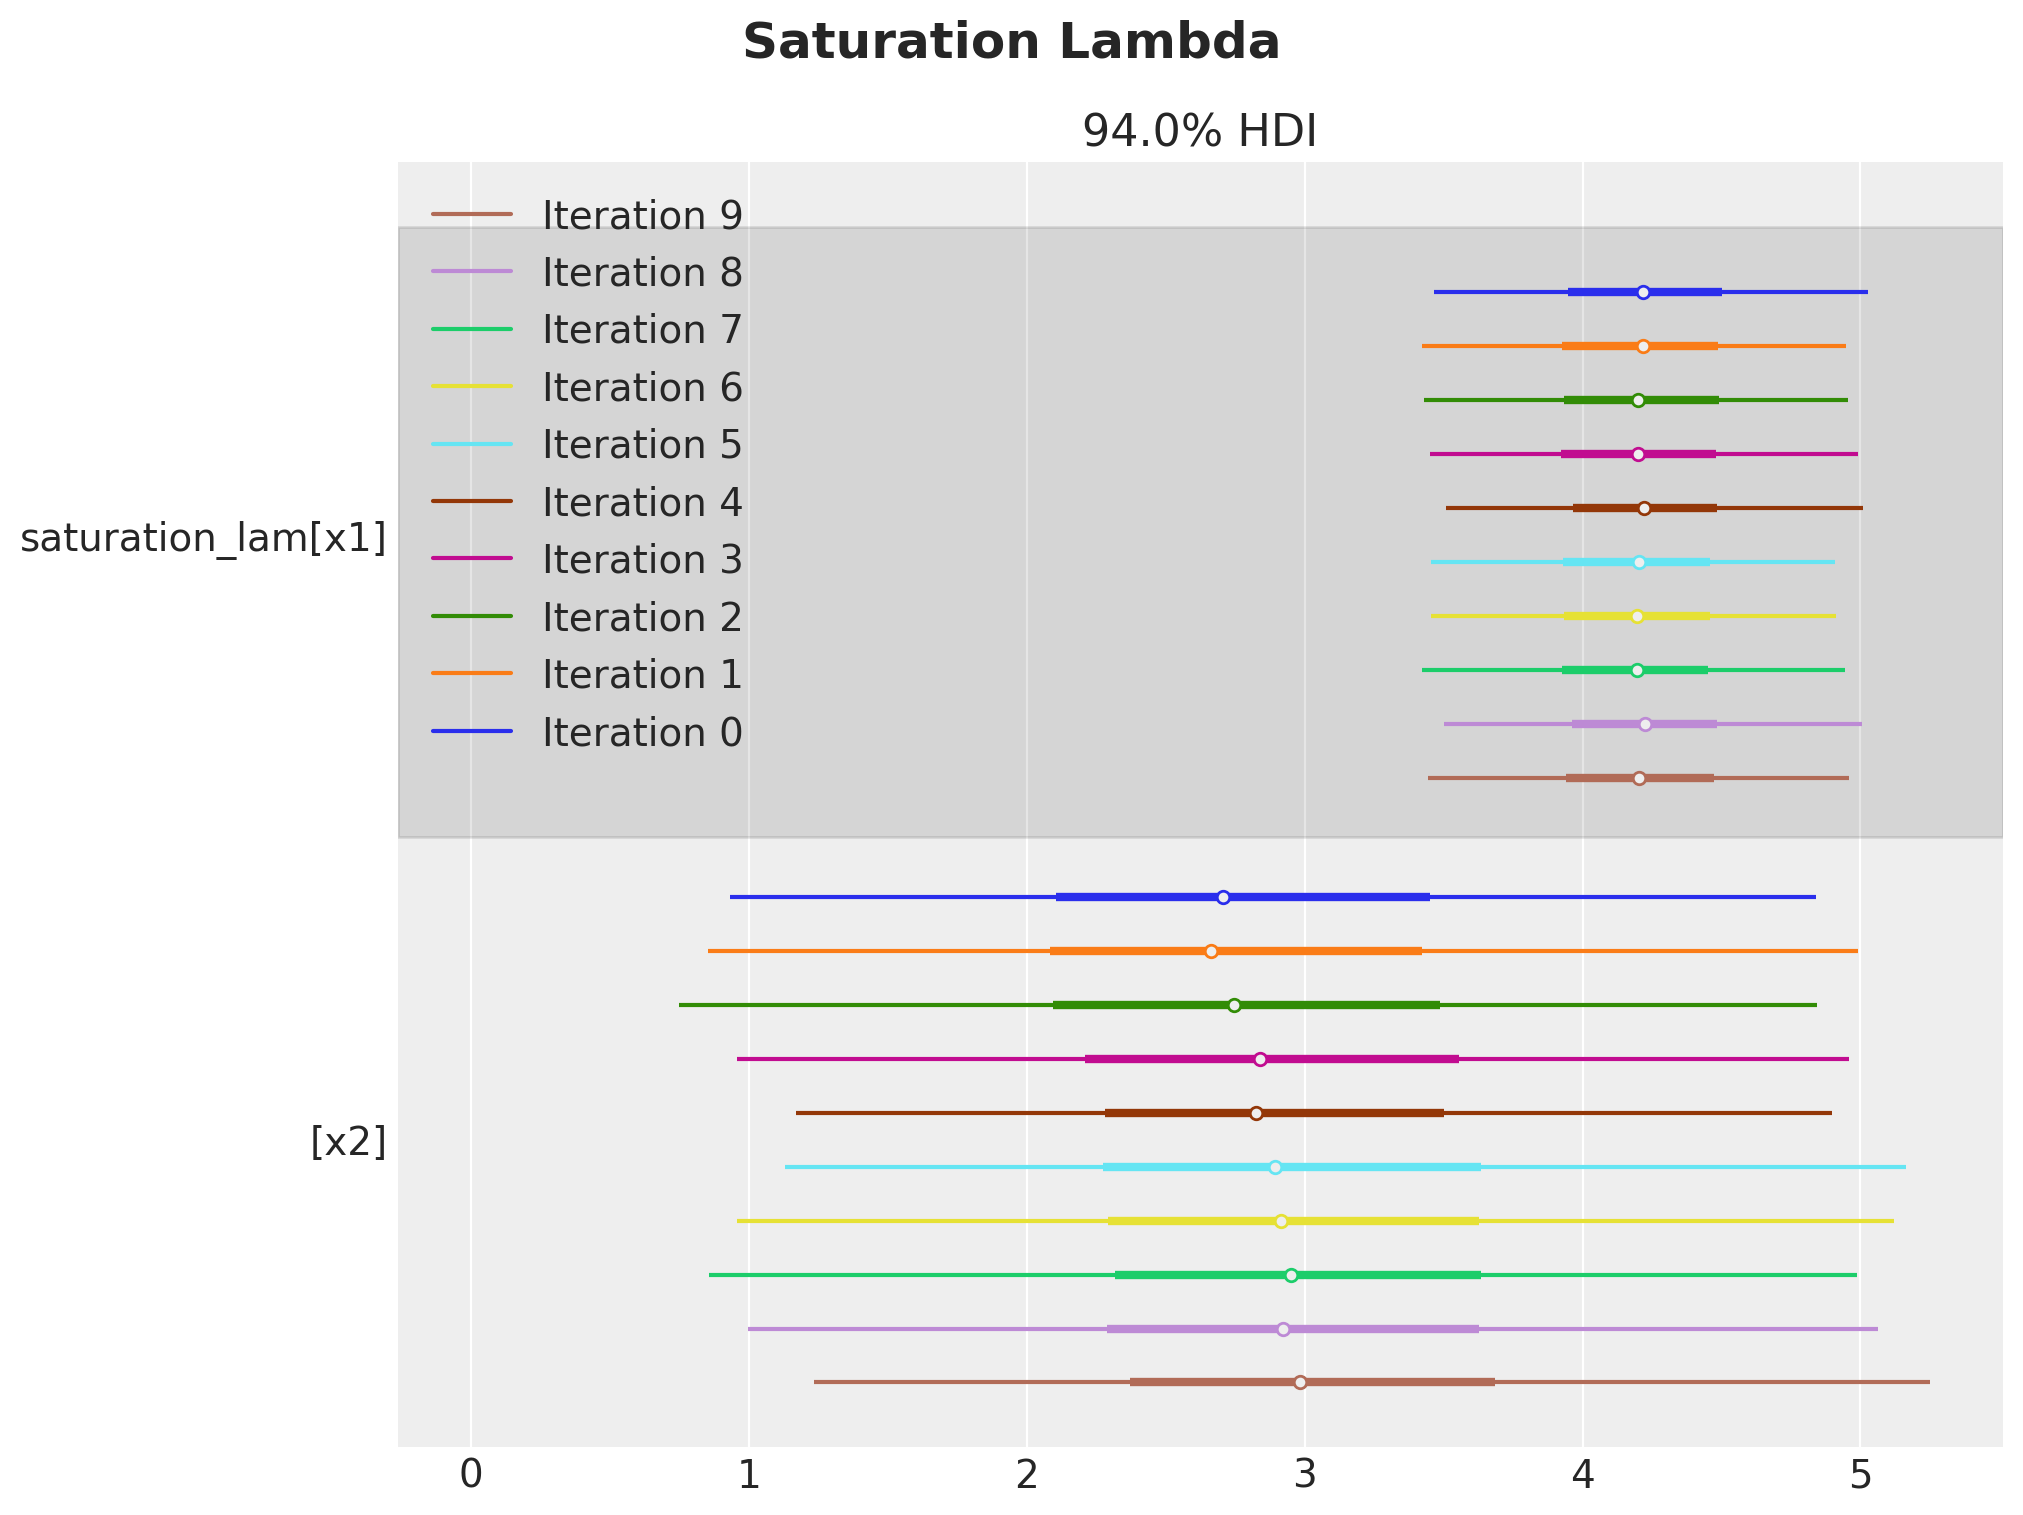

In [13]:
fig, ax = plt.subplots(figsize=(10, 7))

az.plot_forest(
    data=[result.mmm.idata["posterior"] for result in results],
    model_names=[f"Iteration {i}" for i in range(n_iterations)],
    var_names=["saturation_lam"],
    combined=True,
    ax=ax,
)
fig.suptitle("Saturation Lambda", fontsize=18, fontweight="bold", y=1.06);

The parameters seem to be stable over time. This implies that the estimates ROAS will not change abruptly over time.

## Evaluate Out of Sample Predictions

Finally, we evaluate the out of sample predictions. To begin with, we can simply plot the posterior predictive distributions for each iteration for both the training and test data.

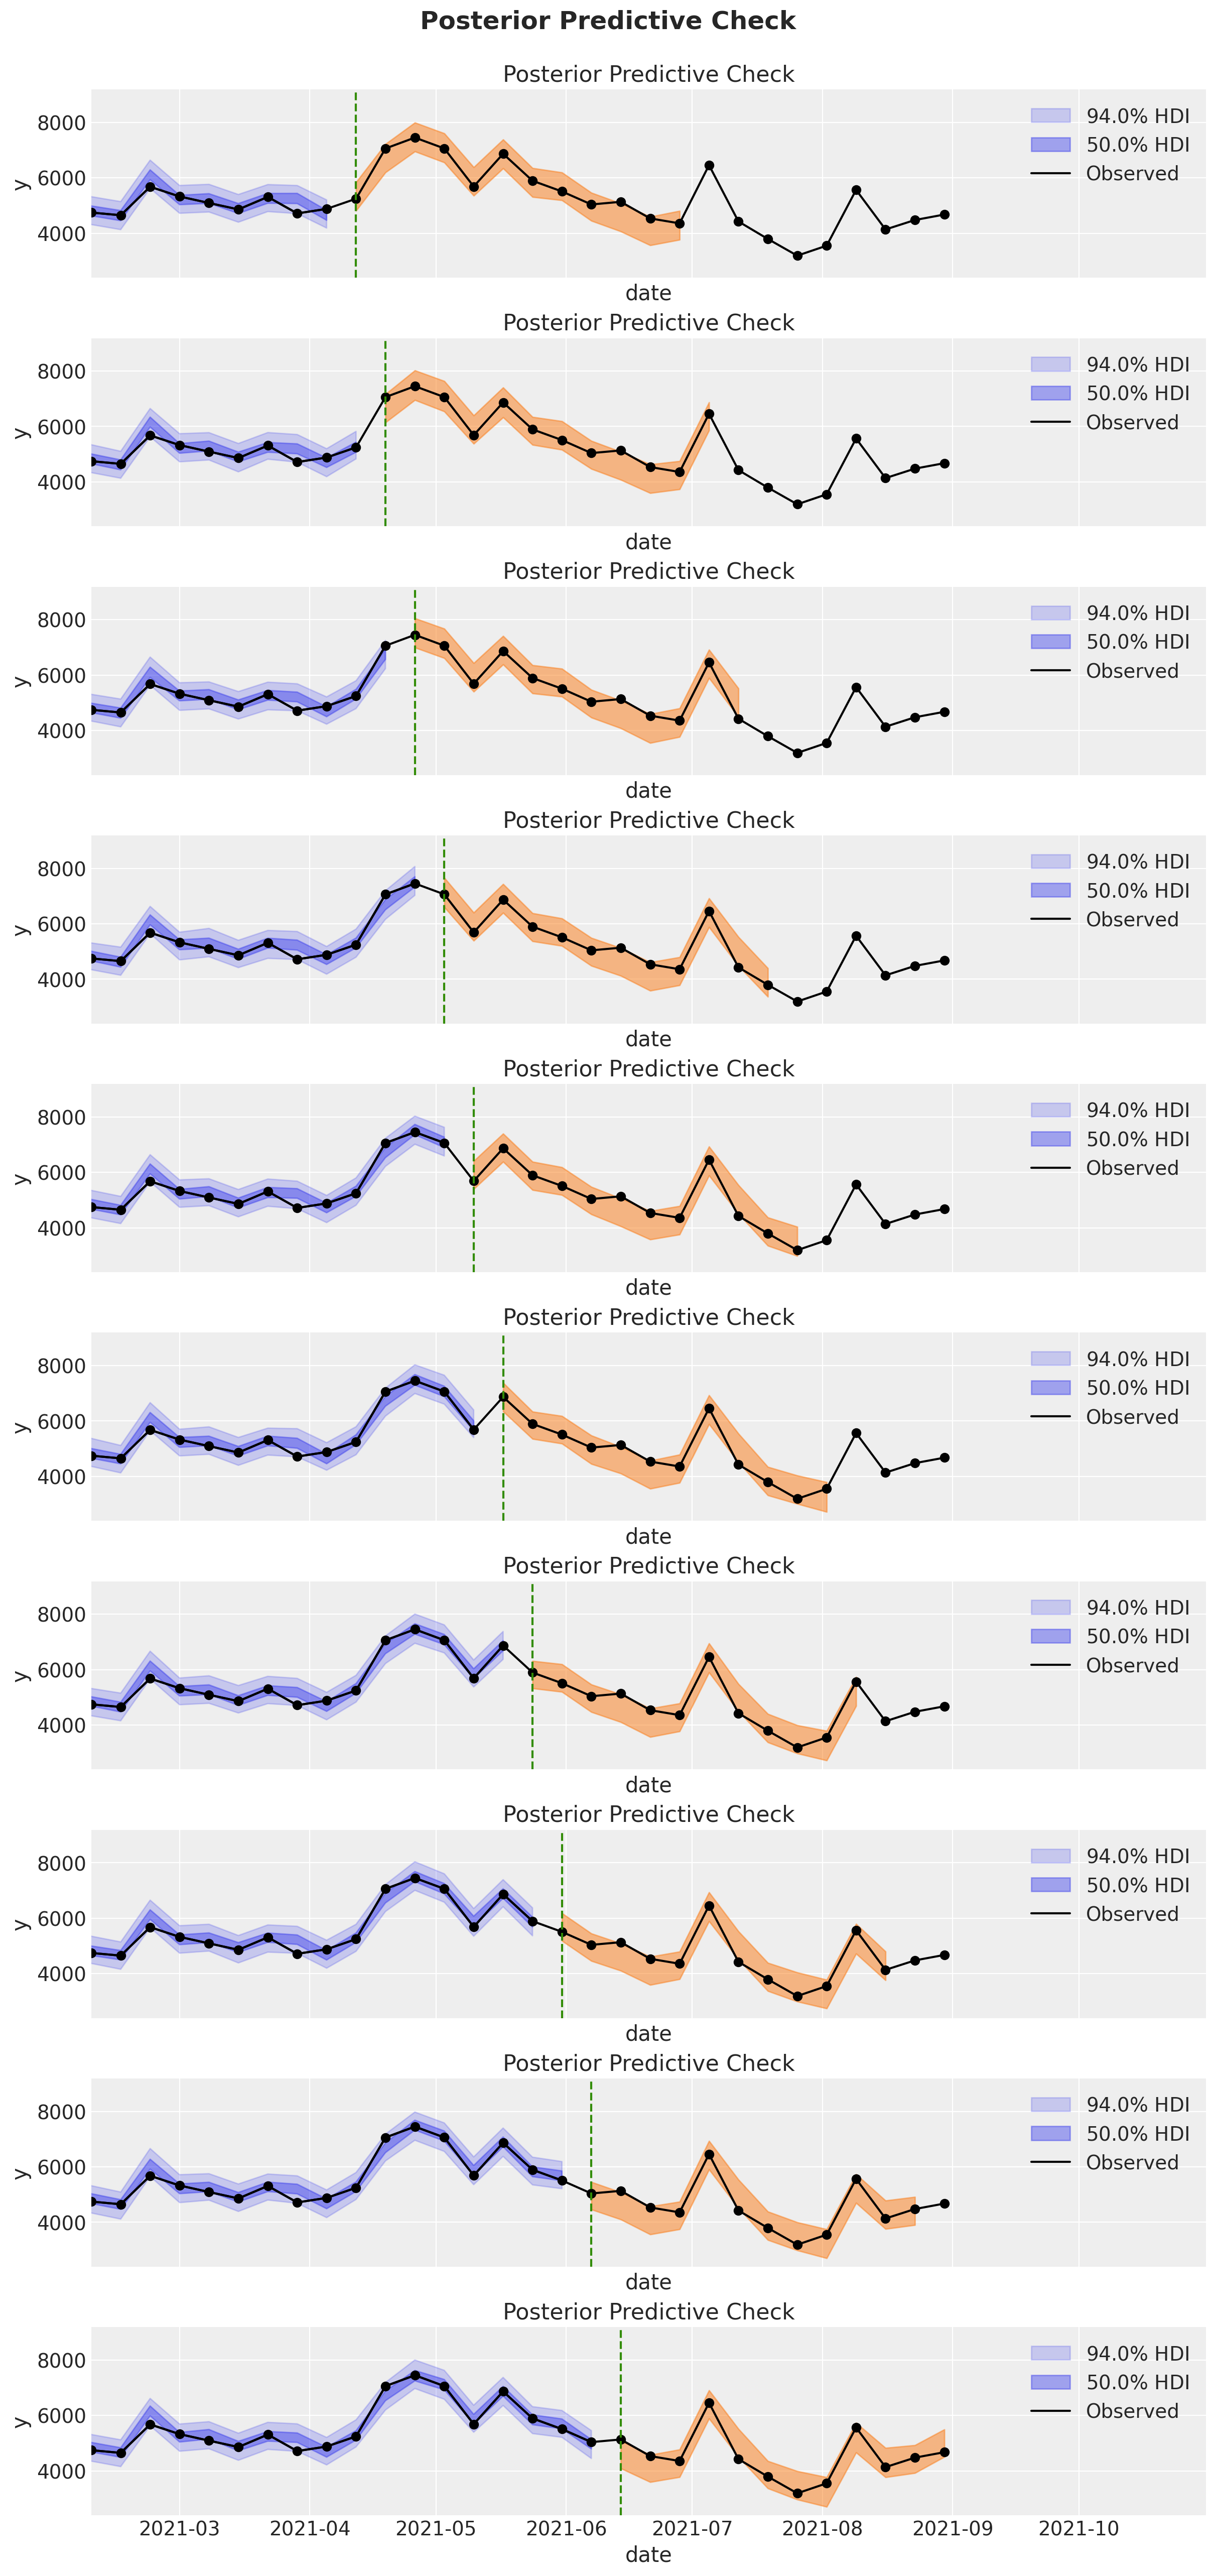

In [14]:
fig, axes = plt.subplots(
    nrows=n_iterations,
    ncols=1,
    figsize=(12, 25),
    sharex=True,
    sharey=True,
    layout="constrained",
)

axes = axes.ravel()

for i, result in enumerate(results):
    ax = axes[i]
    result.mmm.plot_posterior_predictive(original_scale=True, ax=ax)

    test_hdi = az.hdi(result.y_pred_test["y"].to_numpy().T)

    ax.fill_between(
        result.X_test["date_week"],
        test_hdi[:, 0],
        test_hdi[:, 1],
        color="C1",
        alpha=0.5,
    )
    ax.plot(X["date_week"], y, marker="o", color="black")
    ax.axvline(result.X_test["date_week"].iloc[0], color="C2", linestyle="--")

axes[-1].set(xlim=(X["date_week"].iloc[n_init - 9], None))
fig.suptitle("Posterior Predictive Check", fontsize=18, fontweight="bold", y=1.02);

Overall, the out of sample predictions look very good 🚀!

We can quantify the model performance using the Continuous Ranked Probability Score (CRPS).

> *“The CRPS — Continuous Ranked Probability Score — is a score function that compares a single ground truth value to a Cumulative Distribution Function. It t can be used as a metric to evaluate a model’s performance when the target variable is continuous and the model predicts the target’s distribution; Examples include Bayesian Regression or Bayesian Time Series models.”*


For a nice explanation of the CRPS, check out this [blog post](https://towardsdatascience.com/crps-a-scoring-function-for-bayesian-machine-learning-models-dd55a7a337a8).

In PyMC Marketing, we provide the function {func}`crps <pymc_marketing.metrics.crps>` to compute this metric. We can use it to compute the CRPS score for each iteration.

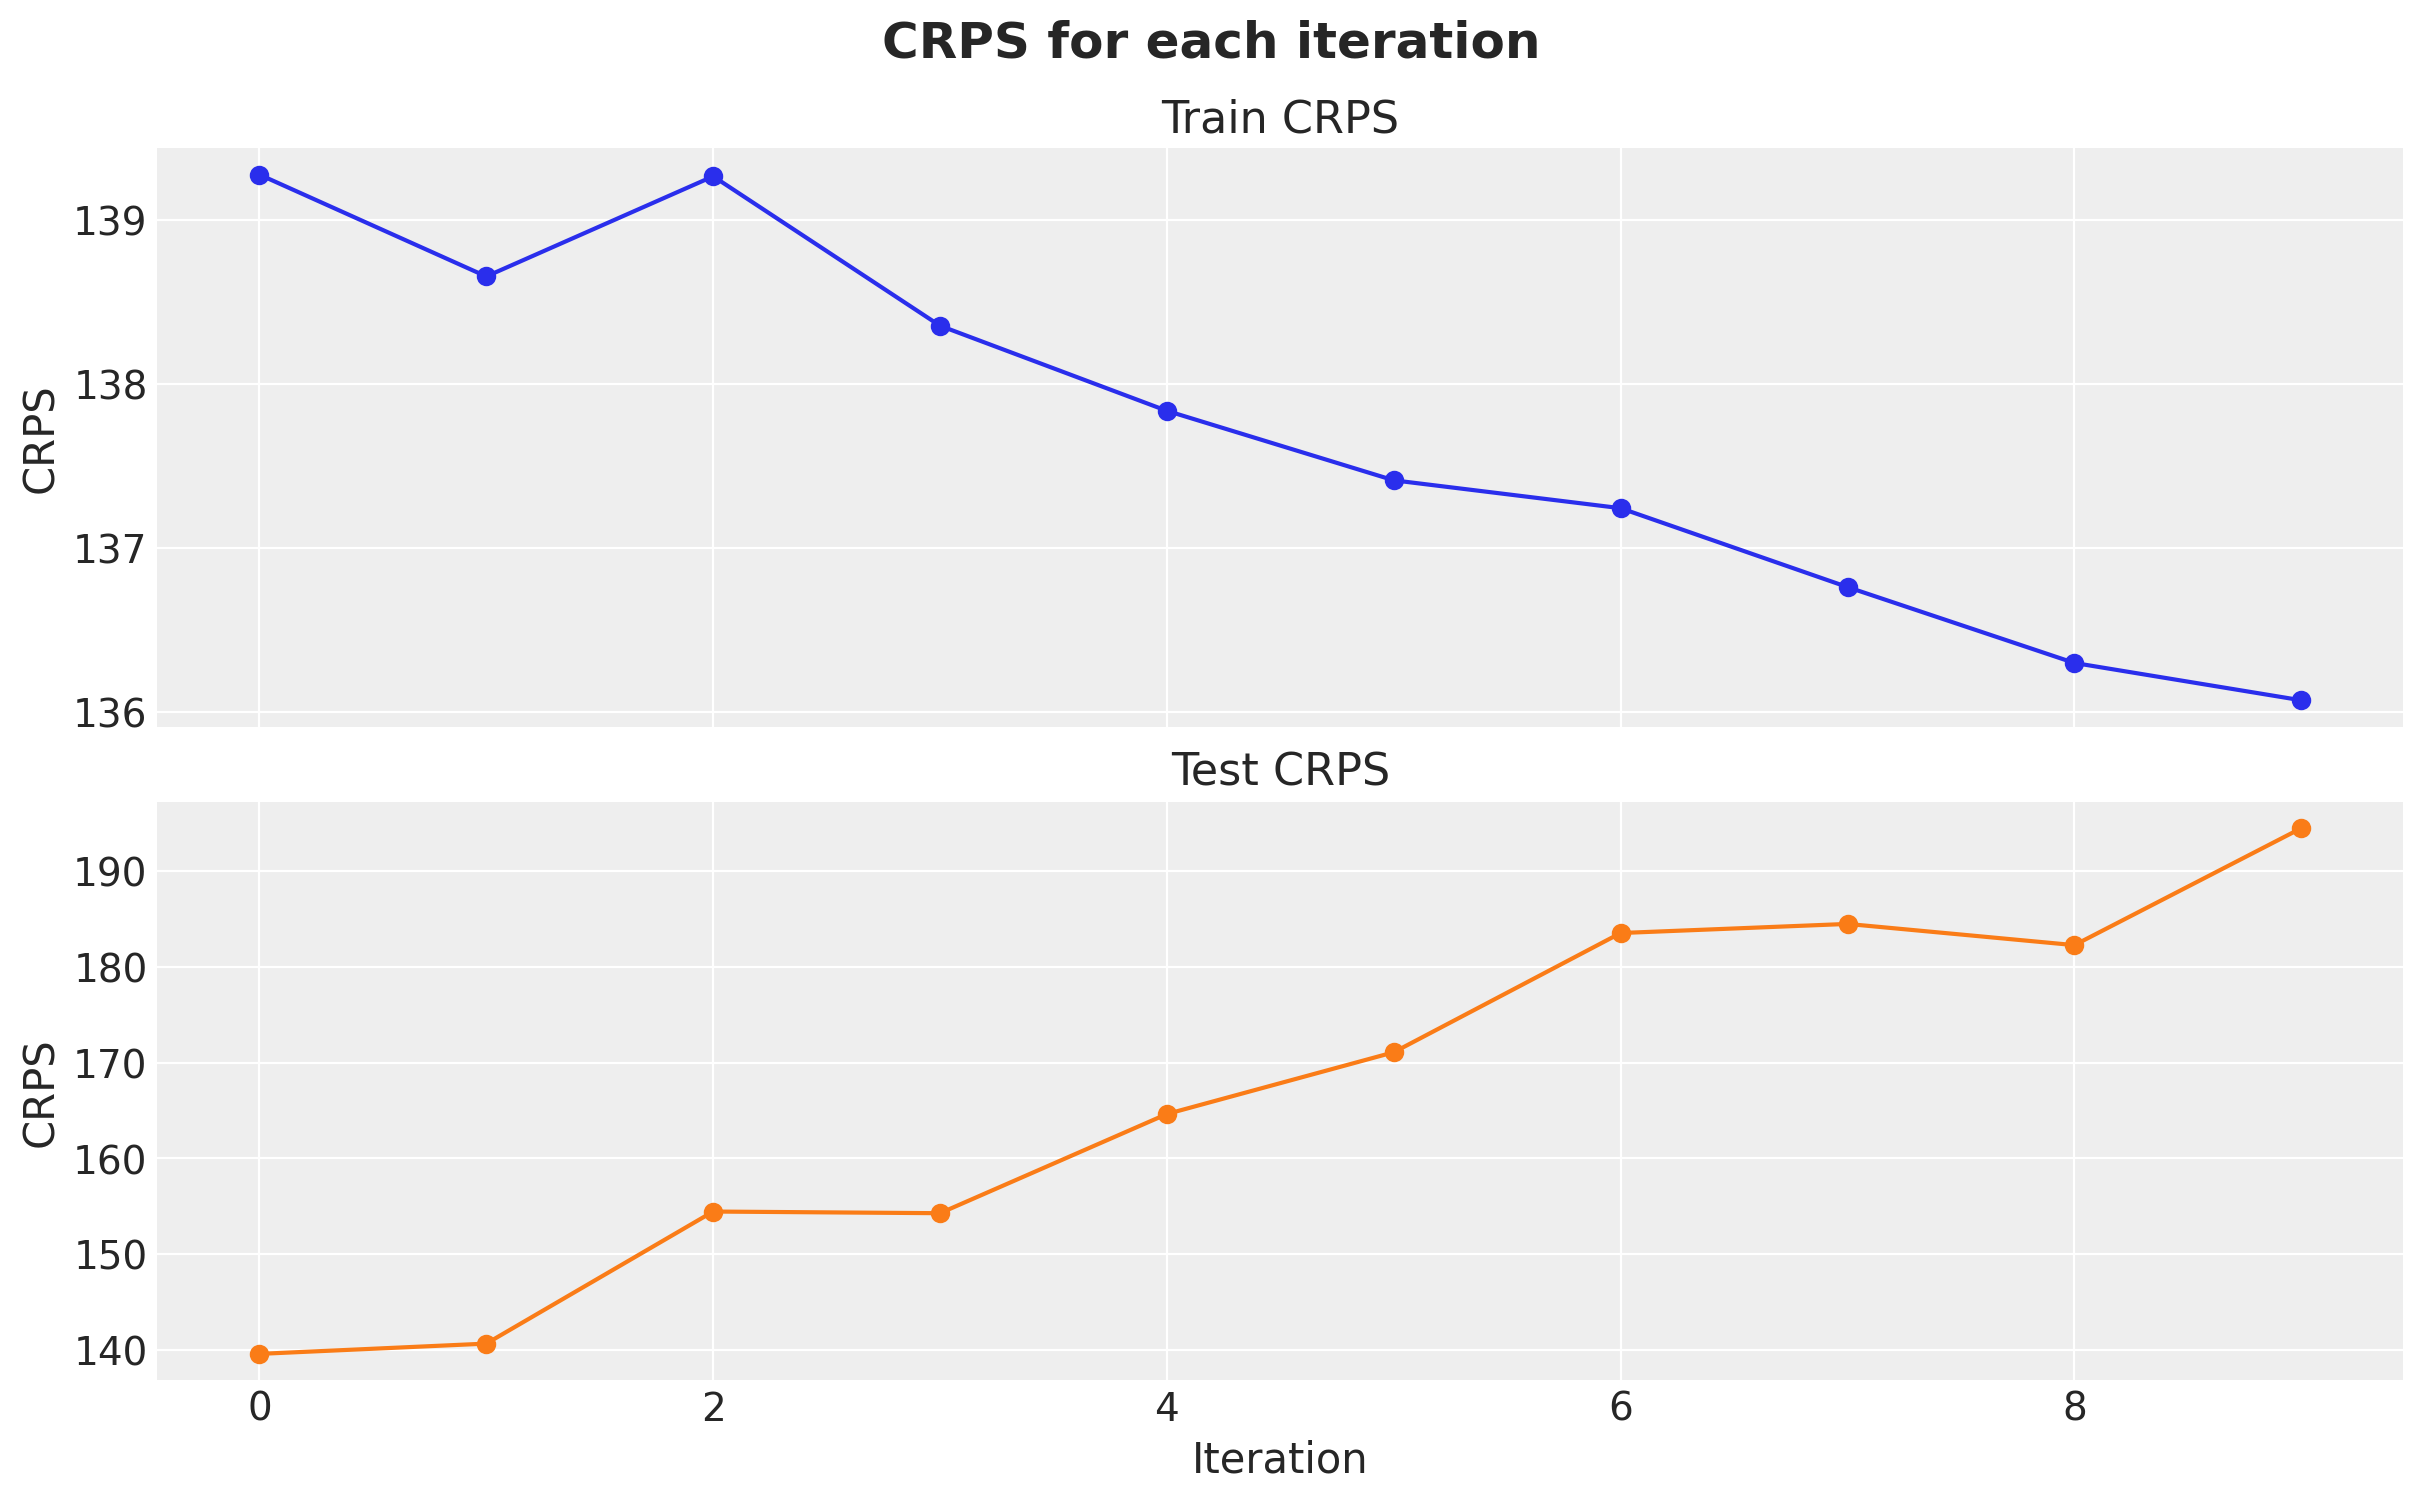

In [15]:
crps_results_train: list[float] = [
    crps(
        y_true=result.y_train.to_numpy(),
        y_pred=az.extract(
            # Scale the predictions back to the original scale
            apply_sklearn_transformer_across_dim(
                data=result.mmm.idata.posterior_predictive["y"],
                func=result.mmm.get_target_transformer().inverse_transform,
                dim_name="date",
            )
        )["y"]
        .to_numpy()
        .T,
    )
    for result in results
]


crps_results_test: list[float] = [
    crps(
        y_true=result.y_test.to_numpy(),
        y_pred=result.y_pred_test["y"].to_numpy().T,
    )
    for result in results
]

fig, ax = plt.subplots(
    nrows=2, ncols=1, figsize=(12, 7), sharex=True, sharey=False, layout="constrained"
)

ax[0].plot(crps_results_train, marker="o", color="C0", label="train")
ax[0].set(ylabel="CRPS", title="Train CRPS")
ax[1].plot(crps_results_test, marker="o", color="C1", label="test")
ax[1].set(xlabel="Iteration", ylabel="CRPS", title="Test CRPS")
fig.suptitle("CRPS for each iteration", fontsize=18, fontweight="bold", y=1.05);

Event hough the visual results look great, we see that the CRPS mildly decreases for the training data while it increases for the test data as we increase the size of the training data. This is a sign that we are overfitting the model to the training data. Some strategies to overcome this issue include using regularization techniques and re-evaluate the model specification. This should be an iterative process.

In [16]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pymc_marketing,pytensor,numpyro

Last updated: Sun Aug 25 2024

Python implementation: CPython
Python version       : 3.12.4
IPython version      : 8.26.0

pymc_marketing: 0.8.0
pytensor      : 2.22.1
numpyro       : 0.15.2

numpy     : 1.26.4
arviz     : 0.19.0
matplotlib: 3.9.0
pandas    : 2.2.2

Watermark: 2.4.3

